In [41]:
import requests
url = "https://github.com/laxmimerit/All-CSV-ML-Data-Files-Download/raw/refs/heads/master/db_samples/Chinook.db"

response = requests.get(url)

if response.status_code == 200:
    with open("Chinook.db", "wb") as file:
        file.write(response.content)

    print("File downloaded successfully")

else:
    print("Failed to download the file")
    print(response.status_code)

File downloaded successfully


In [42]:
from langchain_community.utilities import SQLDatabase
db = SQLDatabase.from_uri("sqlite:///Chinook.db") 
# db.dialect 
# db.get_usable_table_names()
# db.run("select * from customer limit 2")

In [59]:

from typing_extensions import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END 
from initializeLLM import get_openai_llm
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()


class State(TypedDict):
    question:str 
    sql_query: str
    sql_result: str
    answer: str

In [50]:
from langchain import hub

class SQLQuery(TypedDict):
    """Generated SQL query."""
    query: Annotated[str, ..., "Syntactically valid SQL query."]


def get_sql_query(state:State):
    """Generate syntactically valid SQL query from the user question"""
    
    prompt = hub.pull("langchain-ai/sql-query-system-prompt")
    prompt = prompt.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    llm = get_openai_llm()
    llm = llm.with_structured_output(SQLQuery)
    response = llm.invoke(prompt)
    return {"sql_query": response["query"]}


def sql_query_executor(state:State):
    """Execute the SQL query and return the result"""
    sql_query = state['sql_query']
    result = db.run(sql_query)
    return {"sql_result": str(result)} 

def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f"Question: {state['question']}\n"
        f"SQL Query: {state['sql_query']}\n"
        f"SQL Result: {state['sql_result']}"
    )
    llm = get_openai_llm()
    response = llm.invoke(prompt)
    return {"answer": response.content}

In [45]:
def see_graph(app):
    from IPython.display import display, Image
    image = Image(app.get_graph().draw_mermaid_png())
    display(image)

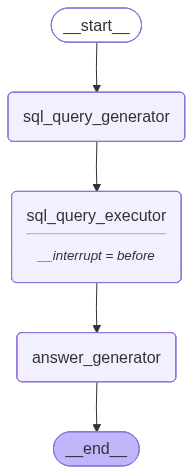

In [60]:

#Option1

graph = StateGraph(State)
graph.add_node("sql_query_generator", get_sql_query)
graph.add_edge(START, "sql_query_generator") 
graph.add_node("sql_query_executor", sql_query_executor)
graph.add_edge("sql_query_generator", "sql_query_executor") 
graph.add_node("answer_generator", generate_answer)
graph.add_edge("sql_query_executor", "answer_generator")    
graph = graph.compile(checkpointer=memory, interrupt_before=["sql_query_executor"])
see_graph(graph)


# Option2


# graph_builder = StateGraph(State).add_sequence(
#     [get_sql_query, sql_query_executor, generate_answer]
# )
# graph_builder.add_edge(START, "get_sql_query") 
# graph = graph_builder.compile(checkpointer=memory, interrupt_before=["sql_query_executor"])
# see_graph(graph)

In [63]:
try:
    user_approval = input("Do you want to go to execute query? (yes/no): ")
except Exception:
    user_approval = "no"

if user_approval.lower() == "yes":
    config = {"configurable":{"thread_id": 1234}}
    query = {"question":"How many customers are there in the database?"}
    for step in graph.stream(query, config, stream_mode="updates"):
        print(step)
else:
    print("Operation cancelled by user.")

/Users/asharafansari/.local/share/virtualenvs/langgrpah-J1LXgy-w/lib/python3.9/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


{'sql_query_generator': {'sql_query': 'SELECT COUNT(CustomerId) AS TotalCustomers FROM Customer;'}}
{'__interrupt__': ()}


Approach 2

In [ ]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
toolkit = SQLDatabaseToolkit(db=db, llm=get_openai_llm())
tools = toolkit.get_tools()
tools

/Users/asharafansari/.local/share/virtualenvs/langgrpah-J1LXgy-w/lib/python3.9/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


ChatPromptTemplate(input_variables=['dialect', 'top_k'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'langchain-ai', 'lc_hub_repo': 'sql-agent-system-prompt', 'lc_hub_commit_hash': '31156d5fe3945188ee172151b086712d22b8c70f8f1c0505f5457594424ed352'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['dialect', 'top_k'], input_types={}, partial_variables={}, template='You are an agent designed to interact with a SQL database.\nGiven an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.\nUnless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.\nYou can order the results by a relevant column to return the most interesting examples in the database.\nNever query for all the columns from a specific table, only ask for the relevant columns given the question.\nYou have access to tools for interact

In [75]:
from langchain import hub 
prompt = hub.pull("langchain-ai/sql-agent-system-prompt")
prompt = prompt.invoke({"dialect": db.dialect, "top_k": 10})
system_prompt = prompt.messages[0]

/Users/asharafansari/.local/share/virtualenvs/langgrpah-J1LXgy-w/lib/python3.9/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [76]:
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent
llm = get_openai_llm()
agent_executor = create_react_agent(llm, tools, prompt=system_prompt) 

In [77]:
question = "Which country's customers spent the most?"
for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which country's customers spent the most?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_NJeykJkdjJrGjigHHASfKE80)
 Call ID: call_NJeykJkdjJrGjigHHASfKE80
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_mzfZq38WBi7rnsCeSuAz1XJ8)
 Call ID: call_mzfZq38WBi7rnsCeSuAz1XJ8
  Args:
    table_names: Customer
  sql_db_schema (call_6o6UdB6Uz2Sm2S6jqqEhDq63)
 Call ID: call_6o6UdB6Uz2Sm2S6jqqEhDq63
  Args:
    table_names: Invoice
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Invoice" (
	"Inv

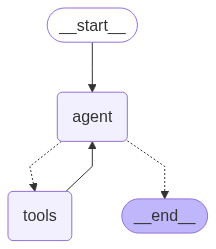

In [78]:
see_graph(agent_executor)